In [1]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/su/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
### create data!

# parameters
dt = 1 / 100
angvel_magnitude = 1
num_steps = int(360 / (dt * angvel_magnitude) + 1)       # dt [s] * angvel_magnitude [deg/s] * num [] = 360 [deg]
rng = np.random.default_rng(2021)

# initialize time, position, and orientation
t = 0
p = np.array([.0, .0, .0])
r = R.identity()
q = r.as_quat()

data = np.empty((num_steps, 8))

# generate time, position, and rotation data
# for i, angle in enumerate(np.linspace(0, 360, num=num_steps, endpoint=True)):
#     t += dt 
#     p += rng.normal(loc=0, scale=0.01, size=3)
#     r = R.from_euler('zyx', [0,angle,0], degrees=True)
#     q = r.as_quat()
# 
#     # print(r.as_euler('zyx', degrees=True))
#     data[i] = np.array([[t, p[0], p[1], p[2], q[0], q[1], q[2], q[3]]])


for i, angle in enumerate(np.linspace(0, 90, num=num_steps, endpoint=True)):
    t += dt 
    p += rng.normal(loc=0, scale=0.01, size=3)
    r = R.from_euler('zyx', [angle,angle,angle], degrees=True)
    q = r.as_quat()

    # print(r.as_euler('zyx', degrees=True))
    data[i] = np.array([[t, p[0], p[1], p[2], q[0], q[1], q[2], q[3]]])

In [3]:
### export data to file!

filepath = os.getcwd()
filename = "blind_targeting_complex.txt"

# header = ["#", "timestamp(s)", "tx", "ty", "tz", "qx", "qy", "qz", "qw"]



with open(os.path.join(filepath, filename), 'w') as f:
    wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)      # writer handle
    
    # write header
    # wh.writerow(header)

    # write data
    for datum in data:
        # print(['{:.6f}'.format(x) for x in datum])
        wh.writerow(['{:.6f}'.format(x) for x in datum])

0          0.01
5          0.06
10         0.11
15         0.16
20         0.21
          ...  
35980    359.81
35985    359.86
35990    359.91
35995    359.96
36000    360.01
Name: t, Length: 7201, dtype: float64


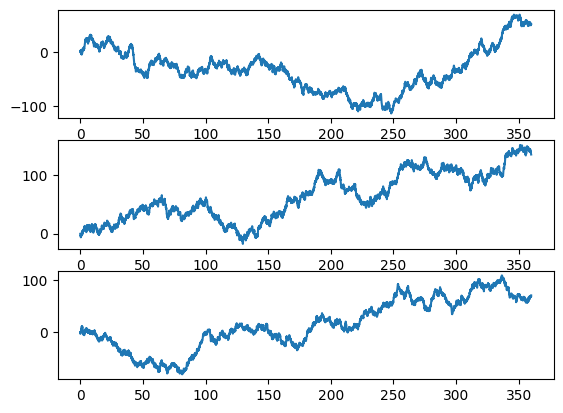

In [4]:


filepath = os.getcwd()
filename = "blind_targeting_complex.txt"

# df = pandas.read_csv(os.path.join(filepath, 'imu_reading/disi/', filename))
df = pd.read_csv(os.path.join(filepath, filename), sep=' ', names = ['t', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])
# df = df.truncate(after=int(30//dt))
print(df.t[::5])


fig, axes = plt.subplots(3,1)
axes[0].plot(df.t[::5], np.rad2deg(df.tx[::5]))
axes[1].plot(df.t[::5], np.rad2deg(df.ty[::5]))
axes[2].plot(df.t[::5], np.rad2deg(df.tz[::5]))

/tmp/ipykernel_15384/50484625.py:3: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  euler = r.as_euler('zyx')  # Change 'xyz' to any other sequence for different Euler angles


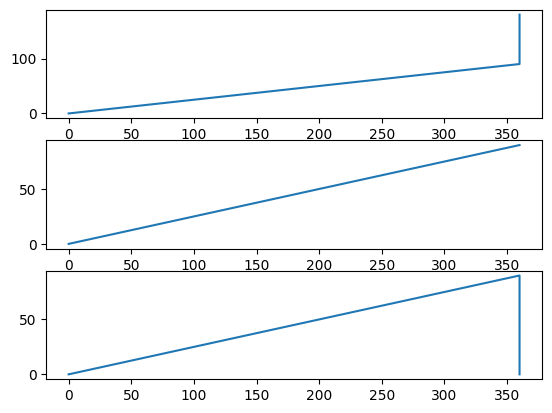

In [5]:
def quaternion_to_euler(q):
    r = R.from_quat(q)  # SciPy expects quaternions in (w, x, y, z) format
    euler = r.as_euler('zyx')  # Change 'xyz' to any other sequence for different Euler angles
    return euler

quats = np.array([df.qx, df.qy, df.qz, df.qw])
quats = np.swapaxes(quats, 0, 1)
euler_angles = np.apply_along_axis(quaternion_to_euler, axis=1, arr=quats)


fig, axes = plt.subplots(3,1)
axes[0].plot(df.t, np.rad2deg(euler_angles[:,0]))
axes[1].plot(df.t, np.rad2deg(euler_angles[:,1]))
axes[2].plot(df.t, np.rad2deg(euler_angles[:,2]))

In [6]:
timetsamps = np.array(df.t)
gyro_meas  = np.array([df.w_x, df.w_y, df.w_z]).T
quats = R.from_quat(np.array([df.q_x, df.q_y, df.q_z, df.q_w]).T)
quats *= quats[0].inv()
# print(quats[-1].as_matrix())

# R_diff = R.from_matrix(quats[-1].as_matrix() @ quats[0].as_matrix().T)
# print(R_diff.as_matrix())

num_data = len(timetsamps)
dt = (timetsamps[-1] - timetsamps[0]) / (num_data-1)


AttributeError: 'DataFrame' object has no attribute 'w_x'

In [ ]:
qtmp = R.identity()
qtmp = qtmp.as_quat()
qtmp = np.hstack([qtmp[-1], qtmp[:-1]])
qtmp

In [ ]:
class AttitudeEstimator():
    def __init__(self):
        self.q = R.identity()
    
    def predict(self, gyro: np.array, dt: float, eps=1e-6):

        # attitude update (rotate by gyroscope), we do this in quaternions
        # this is the gyroscope angular velocity integrated over the sample period
        dtwx = dt*gyro[0]
        dtwy = dt*gyro[1]
        dtwz = dt*gyro[2]

        '''
        # compute the quaternion values in [x,y,z,w] order
        angle = np.sqrt(dtwx*dtwx + dtwy*dtwy + dtwz*dtwz) + eps
        ca = np.cos(angle/2.0)
        sa = np.sin(angle/2.0)        
        dq = np.array([sa*dtwx/angle , sa*dtwy/angle , sa*dtwz/angle, ca])
        
        q = self.q.as_quat()

        # rotate the quad's attitude by the delta quaternion vector computed above
        tmpqx = dq[0]*q[3] + dq[3]*q[0] + dq[2]*q[1] - dq[1]*q[2]
        tmpqy = dq[1]*q[3] - dq[2]*q[0] + dq[3]*q[1] + dq[0]*q[2]
        tmpqz = dq[2]*q[3] + dq[1]*q[0] - dq[0]*q[1] + dq[3]*q[2]
        tmpqw = dq[3]*q[3] - dq[0]*q[0] - dq[1]*q[1] - dq[2]*q[2]

        # normalize and store the result
        norm = np.sqrt(tmpqw*tmpqw + tmpqx*tmpqx + tmpqy*tmpqy + tmpqz*tmpqz) + eps
        self.q = R.from_quat([tmpqx/norm, tmpqy/norm, tmpqz/norm, tmpqw/norm])
        '''

        # qdot = exp(theta) * q
        # q_kp1 = dq * q_k
        # dq is the exponential mapping of pure quaternion theta = w*dt
        # dq = qw * I_4x4 + [[0 -qv'], [qv, [qv]_x]]
        # q_k is the orientation of robot's body frame w.r.t. global frame, i.e., q_BtoW (= q_ItoG)
        
        # compute the quaternion values in [w,x,y,z] order
        angle = np.sqrt(dtwx*dtwx + dtwy*dtwy + dtwz*dtwz) + eps
        ca = np.cos(angle/2.0)
        sa = np.sin(angle/2.0)
        dq = np.array([ca, sa*dtwx/angle , sa*dtwy/angle , sa*dtwz/angle])
        
        # change [x,y,z,w] to [w,x,y,z]
        q = self.q.as_quat()
        q = np.hstack([q[-1], q[:-1]])

        # rotate the quad's attitude by the delta quaternion vector computed above
        # this is what I used to think wrong but correct
        tmpqw = dq[0]*q[0] - dq[1]*q[1] - dq[2]*q[2] - dq[3]*q[3]
        tmpqx = dq[1]*q[0] + dq[0]*q[1] + dq[3]*q[2] - dq[2]*q[3]
        tmpqy = dq[2]*q[0] - dq[3]*q[1] + dq[0]*q[2] + dq[1]*q[3]
        tmpqz = dq[3]*q[0] + dq[2]*q[1] - dq[1]*q[2] + dq[0]*q[3]

        # normalize and store the result
        norm = np.sqrt(tmpqw*tmpqw + tmpqx*tmpqx + tmpqy*tmpqy + tmpqz*tmpqz) + eps
        self.q = R.from_quat([tmpqx/norm, tmpqy/norm, tmpqz/norm, tmpqw/norm])


In [ ]:
estimator = AttitudeEstimator()

for i, t in enumerate(timetsamps):
    estimator.predict(gyro_meas[i], dt)
    
    # if i % 100 == 0:
    #     print(i, gyro_meas[i], estimator.q.as_quat())

In [ ]:
for i in range(0, len(timetsamps), len(timetsamps)//10):
    r = quats[i].inv()
    print(i, r.as_quat(), r.as_euler('zyx', degrees=True))

In [ ]:
print(quats[-1].inv().as_quat())
print(estimator.q.as_quat())

# compute error
q_err = quats[-1] * estimator.q
print(f"error: {np.rad2deg(q_err.magnitude())} [deg]")